In [871]:
import time
from filterpy.leastsq import LeastSquaresFilter
from pykalman import KalmanFilter
now=time.time()


class Localize:
    
    def __init__(self, gx=0, gy=0, gyaw=0, ix=0, iy=0, iyaw=0,init_x=0,init_y=0):
        
        initial_state_mean = [0,
                      init_x,
                      0,
                      init_y]

        transition_matrix = [[1, 1, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, 1],
                             [0, 0, 0, 1]]

        observation_matrix = [[1, 0, 0, 0],
                              [0, 0, 1, 0]]
        
        initial_state_covariance=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
        
        self.kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)
        
        self.kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)
        
        # gps coordinates
        
        self.gx=gx
        self.gy=gy
        self.gyaw=0

        self.g_arr=[(0,0)]
        # self.gy_arr=[]
        self.gyaw_arr=[]
        
        # imu coordinate estimate
        self.ix=ix
        self.iy=iy
        
        self.i_arr=[(0,0)]
        
        #imu data         
        self.iyaw=0
        self.ipitch=0
        self.iroll=0
        
        self.iyaw_arr=[]
        self.ipitch_arr=[]
        self.iroll_arr=[]
        
        #imu accelerometer data
        self.accelx=0
        self.accely=0
        self.accelz=0
        
        #for physics
        self.ux=0
        self.uy=0
        self.fix_dt=0.1
        self.var_dt=0.1
        
        #last update time to calculate dt
        self.lupdate_i=0
        self.lupdate_g=0
        
        self.lsq_gx = LeastSquaresFilter(dt=0.01, order=2)
        self.lsq_gy = LeastSquaresFilter(dt=0.01, order=2)
        
        self.lsq_ix = LeastSquaresFilter(dt=0.01, order=2)
        self.lsq_iy = LeastSquaresFilter(dt=0.01, order=2)
        
        self.g_state_means = [initial_state_mean]
        self.g_state_covariances = [initial_state_covariance]
        
        self.i_state_means = [initial_state_mean]
        self.i_state_covariances = [initial_state_covariance]
        
    def update_imu(self, iyaw,ipitch,iroll,ax,ay,az):
        self.iyaw=iyaw
        self.ipitch=ipitch
        self.iroll=iroll
        
        self.iyaw_arr.append(iyaw)
        self.ipitch_arr.append(ipitch)
        self.iroll_arr.append(iroll)
        
        self.var_dt=now()-self.lupdate_i
        self.lupdate_i=now()
        
        # v = u + at
        self.ux=self.ux + self.accelx*self.var_dt
        self.uy=self.uy + self.accely*self.var_dt
        
        # s = ut + 0.5at^2
        self.ix=self.ix+(self.ux*self.var_dt+0.5*self.accelx*self.var_dt)
        self.iy=self.iy+(self.uy*self.var_dt+0.5*self.accely*self.var_dt)
        
        self.i_arr.append((self.ix,self.iy))
        # self.iy_arr.append(self.iy)
    
    def update_gps(self, gx,gy,gyaw):
        self.gx=gx
        self.gy=gy
        self.gyaw=gyaw
        
        self.g_arr.append((gx,gy))

    
    def get_loc_lls(self):
        self.lsq_gx.dt=self.var_dt
        self.lsq_gy.dt=self.var_dt
        self.lsq_ix.dt=self.var_dt
        self.lsq_iy.dt=self.var_dt
        
        return self.lsq_gx.update(self.gx)[0], self.lsq_gy.update(self.gy)[0], self.lsq_ix.update(self.ix)[0], self.lsq_iy.update(self.iy)[0]  
        
    def update_lls(self,iyaw=None,ipitch=None,iroll=None,ax=None,ay=None,az=None,gx=None,gy=None,gyaw=None):
        
        if iyaw is not None:
            self.update_imu(iyaw,ipitch,iroll,ax,ay,az)
        if gx is not None and gy is not None:
            self.update_gps(gx,gy,gyaw)
        return self.get_loc_lls()
    
    def get_loc(self):
        pass

        
    
    def update(self,iyaw=None,ipitch=None,iroll=None,ax=None,ay=None,az=None,gx=None,gy=None,gyaw=None):
        rgx,rgy,rix,riy=None,None,None,None
        
        if iyaw is not None:
            self.update_imu(iyaw,ipitch,iroll,ax,ay,az)
            imean,icov=self.kf1.filter_update(filtered_state_mean=self.i_state_means[-1], filtered_state_covariance=self.i_state_covariances[-1], observation=(ix,iy))
            self.i_state_means.append(imean)
            self.i_state_covariances.append(icov)
            
            rix,riy=imean[0],iconv[-1][2]
            if len(self.i_arr)<10:
                rix,riy=self.ix,self.iy
            
            if len(self.i_arr)%10==0:
                self.kf1=self.kf1.em(self.i_arr, n_iter=5)
                # self.kf1.observation_covariance=10*self.kf1.observation_covariance
            
            if len(self.i_arr)==10:
                # print("in here")
                # self.kf1.observation_covariance=10*self.kf1.observation_covariance
                pass
            
        if gx is not None and gy is not None:
            self.update_gps(gx,gy,gyaw)
            
            gmean,gcov=self.kf2.filter_update(filtered_state_mean=self.g_state_means[-1], filtered_state_covariance=self.g_state_covariances[-1],observation= (gx,gy))
            self.g_state_means.append(gmean)
            self.g_state_covariances.append(gcov)
            # gsm,gsc=self.kf2.smooth(self.g_arr)

            rgx,rgy=gmean[0],gmean[2]
            if len(self.g_arr)<10:
                rgx,rgy=self.gx,self.gy
                
            self.ix,self.iy=rgx,rgy
            rix,riy=rgx,rgy
            
            # self.kf2=self.kf2.em(self.g_arr, n_iter=5)
            
            if len(self.g_arr)%10==0:
                self.kf2=self.kf2.em(self.g_arr, n_iter=5)
                # self.kf2.observation_covariance=10*self.kf2.observation_covariance
            
            if len(self.g_arr)==10:
                # print("in here")
                # self.kf2.observation_covariance=10*self.kf2.observation_covariance
                pass
        
        return rix,riy,self.iyaw,self.ipitch,self.iroll

In [872]:
local_sys = Localize()

In [873]:
import numpy as np

In [874]:
import math
X = np.linspace(-14, 14, 100)
Y = np.cos(X)*(X**2)+ 3*np.random.randn(100)
data = np.hstack((X.reshape(100,1),Y.reshape(100,1)))

# measurements = np.asarray([(399,293),(403,299),(409,308),(416,315),(418,318),(420,323),(429,326),(423,328),(429,334),(431,337),(433,342),(434,352),(434,349),(433,350),(431,350),(430,349),(428,347),(427,345),(425,341),(429,338),(431,328),(410,313),(406,306),(402,299),(397,291),(391,294),(376,270),(372,272),(351,248),(336,244),(327,236),(307,220)])
# X,Y=zip(*measurements)


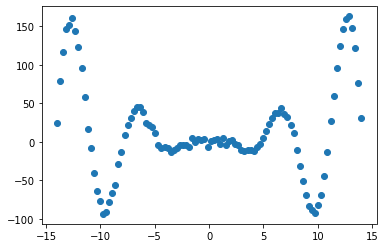

In [875]:
import matplotlib.pyplot as plt
plt.scatter(X,Y)

In [876]:
x,y=[],[]
# data=[(399,293),(403,299),(409,308),(416,315),(418,318),(420,323),(429,326),(423,328),(429,334),(431,337),(433,342),(434,352),(434,349),(433,350),(431,350),(430,349),(428,347),(427,345),(425,341),(429,338),(431,328),(410,313),(406,306),(402,299),(397,291),(391,294),(376,270),(372,272),(351,248),(336,244),(327,236),(307,220)]
# X,Y=zip(*data)
for i in range(len(Y)):
    a=time.time()
    gx,gy=local_sys.update(gx=X[i],gy=Y[i])
    b=time.time()
    c=b-a
    # print(gx,gy)
    x.append(gx)
    y.append(gy)
    # time.sleep(0.2)

In [877]:
c

0.0005695819854736328

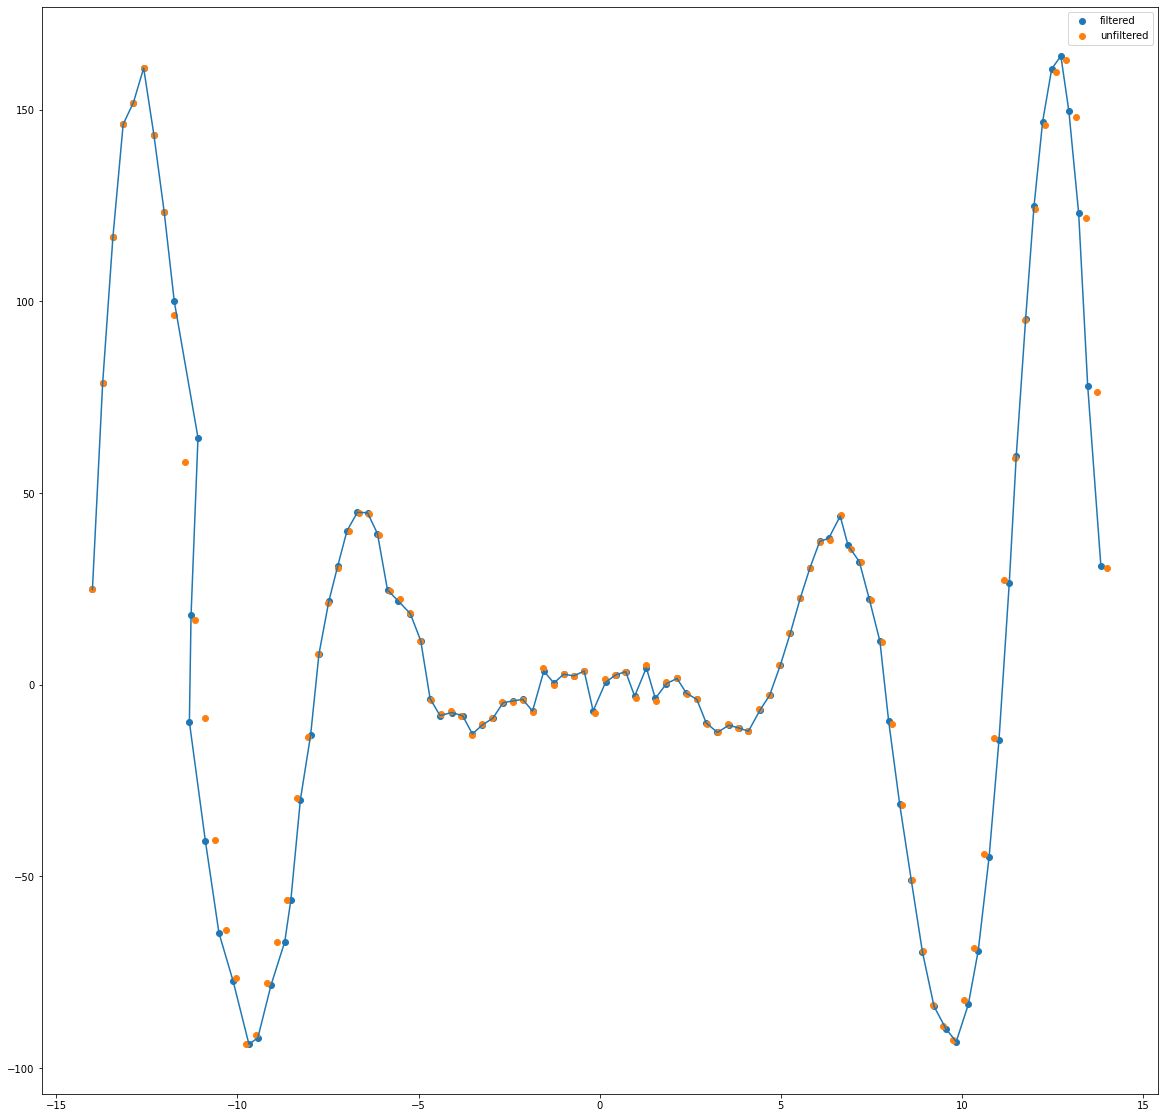

In [878]:
plt.figure(figsize=(20,20))
plt.scatter(x,y,label="filtered")
plt.scatter(X,Y,label="unfiltered")
plt.plot(x,y)
plt.legend()

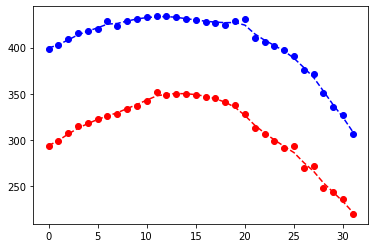

In [879]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import time

measurements = np.asarray([(399,293),(403,299),(409,308),(416,315),(418,318),(420,323),(429,326),(423,328),(429,334),(431,337),(433,342),(434,352),(434,349),(433,350),(431,350),(430,349),(428,347),(427,345),(425,341),(429,338),(431,328),(410,313),(406,306),(402,299),(397,291),(391,294),(376,270),(372,272),(351,248),(336,244),(327,236),(307,220)])

initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

# initial_state_mean = [0,
#                       0,
#                       0,
#                       0]

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

kf1 = kf1.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

plt.figure(1)
times = range(measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',
         times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()